In [1]:
import pandas as pd

# Load your CSV file into a pandas DataFrame
try:
    # ⚠️ IMPORTANT: Replace 'sales_data.csv' with your actual file name and path!
    df = pd.read_csv('sales_store.csv')
    print("Data loaded successfully!")
    print("\nFirst 5 rows of the DataFrame:")
    print(df.head())
    print(f"\nDataFrame shape: {df.shape}")

except FileNotFoundError:
    print("Error: The file 'sales_data.csv' was not found.")
    print("Please check the file name and path.")

Data loaded successfully!

First 5 rows of the DataFrame:
  transaction_id customer_id   customer_name  customer_age  gender product_id  \
0      TXN886726    CUST4481  Dhanush Bhakta          41.0       F      P8464   
1      TXN941069    CUST9221  Anahita Shenoy          46.0       F      P7932   
2      TXN132714    CUST9088    Samaira Bora          29.0  Female      P9223   
3      TXN855235    CUST5938   Yashvi Sachar          44.0    Male      P6308   
4      TXN570157    CUST1985      Rhea Manda          45.0  Female      P5718   

  product_name product_category  quantiy   prce payment_mode purchase_date  \
0         Sofa        Furniture        5  21410          UPI    29-08-2023   
1   Sunglasses      Accessories        2   1156         Cash    04-06-2023   
2   Sunglasses      Accessories        4  13828          UPI    16-09-2023   
3   Smartwatch      Electronics        3  11214          EMI    26-08-2023   
4     Wardrobe        Furniture        4   6120          EMI    2

In [2]:
import sqlite3

# 1. Create a connection to an in-memory SQLite database
# The data will disappear when the connection is closed or the notebook kernel is restarted.
conn = sqlite3.connect(':memory:')

# 2. Write the pandas DataFrame to a SQL table
# 'sales_transactions' is the name we'll use for the SQL table.
# if_exists='replace' ensures that if you run this cell again, the old table is overwritten.
# index=False prevents pandas from adding the DataFrame's index as a column in the SQL table.
df.to_sql('sales_transactions', conn, if_exists='replace', index=False)

print("\nData successfully loaded into the SQL table 'sales_transactions'!")


Data successfully loaded into the SQL table 'sales_transactions'!


In [3]:
# SQL query to count all rows and select a sample
verification_query = """
SELECT
    COUNT(*) AS total_rows,
    *
FROM
    sales_transactions
LIMIT 5;
"""

# Execute the query and read the results back into a new DataFrame
results_df = pd.read_sql_query(verification_query, conn)

print("\nVerification Query Results:")
print(results_df)

# You are now ready to perform complex SQL analysis using this 'conn' object!


Verification Query Results:
   total_rows transaction_id customer_id   customer_name  customer_age gender  \
0        2005      TXN886726    CUST4481  Dhanush Bhakta          41.0      F   

  product_id product_name product_category  quantiy   prce payment_mode  \
0      P8464         Sofa        Furniture        5  21410          UPI   

  purchase_date time_of_purchase   status  
0    29-08-2023         08:16:22  pending  


In [8]:
 # Try to convert to numeric, coercing errors to NaN 
df['prce'] = pd.to_numeric(df['prce'].astype(str).str.replace(r'[$,£]', '', regex=True), errors='coerce')

In [10]:
# The corrected code to silence the warning and ensure correct parsing
df['purchase_date'] = pd.to_datetime(df['purchase_date'], format='%d-%m-%Y', errors='coerce')

In [11]:
df['transaction_id'] = pd.to_numeric(df['transaction_id'], errors='coerce').astype('Int64')

In [12]:
print(df.isnull().sum())

transaction_id      2005
customer_id            3
customer_name          2
customer_age           2
gender                 2
product_id             0
product_name           0
product_category       0
quantiy                0
prce                   0
payment_mode           1
purchase_date          1
time_of_purchase       1
status                 1
price                  0
dtype: int64


In [13]:
# 1. Calculate the median age BEFORE dropping any rows
median_age = df['customer_age'].median()

# 2. Drop rows where critical identifiers are missing
# Drop rows where 'transaction_id', 'customer_id', or 'purchase_date' is NULL/NaN
df.dropna(subset=['transaction_id', 'customer_id', 'purchase_date'], inplace=True)

print(f"Dropped {2005 + 3 + 1} rows due to missing critical IDs or dates.")

Dropped 2009 rows due to missing critical IDs or dates.


In [14]:
# 3. Impute 'customer_age' with the pre-calculated median
df['customer_age'].fillna(median_age, inplace=True)

# 4. Impute remaining categorical columns with 'Unknown'
for col in ['customer_name', 'gender', 'payment_mode', 'time_of_purchase', 'status']:
    df[col].fillna('Unknown', inplace=True)

# Verify cleaning: the total missing values should now be 0
print("\nMissing values remaining after cleaning:")
print(df.isnull().sum())


Missing values remaining after cleaning:
transaction_id      0
customer_id         0
customer_name       0
customer_age        0
gender              0
product_id          0
product_name        0
product_category    0
quantiy             0
prce                0
payment_mode        0
purchase_date       0
time_of_purchase    0
status              0
price               0
dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_7904\2046939568.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['customer_age'].fillna(median_age, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_7904\2046939568.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

In [16]:
# Assuming your original loop structure looked like this:
for col in ['customer_name', 'gender', 'payment_mode', 'time_of_purchase', 'status']:
    # CORRECT WAY: Assign the result of fillna() directly back to the column
    df[col] = df[col].fillna('Unknown')

print("Missing values in categorical columns imputed safely.")

Missing values in categorical columns imputed safely.


In [30]:
print(df.shape)

(2005, 14)


In [32]:
# Check how many rows the filter would KEEP
filter_mask = (df['quantiy'] > 0) & (df['prce'] > 0)
print(f"Rows that satisfy the filter: {filter_mask.sum()}")

Rows that satisfy the filter: 2005


In [34]:
# Apply the filter to keep only transactions with positive quantity and price
df = df[(df['quantiy'] > 0) & (df['prce'] > 0)].copy()

print(f"Final cleaned DataFrame size: {df.shape}")

Final cleaned DataFrame size: (2005, 14)


In [37]:
sql_query_2 = """
SELECT
    product_category,
    SUM(quantiy * prce) AS Total_Category_Revenue,
    COUNT(transaction_id) AS Number_of_Transactions
FROM
    sales_transactions
GROUP BY
    product_category
ORDER BY
    Total_Category_Revenue DESC;
"""
category_breakdown_df = pd.read_sql_query(sql_query_2, conn)
print("\n### 📊 Analysis Results: Revenue by Product Category ###")
print(category_breakdown_df)


### 📊 Analysis Results: Revenue by Product Category ###
  product_category  Total_Category_Revenue  Number_of_Transactions
0      Accessories                10365306                     327
1         Clothing                10258731                     356
2            Books                 9932469                     333
3        Furniture                 9659478                     346
4      Electronics                 9537670                     309
5        Groceries                 9480633                     333


In [41]:
sql_query_atv = """
SELECT
    product_category,
    SUM(quantiy * prce) AS Total_Revenue,
    COUNT(transaction_id) AS Total_Transactions,
    -- Calculate Average Transaction Value (ATV)
    SUM(quantiy * prce) * 1.0 / COUNT(transaction_id) AS ATV
FROM
    sales_transactions
GROUP BY
    product_category
ORDER BY
    ATV DESC;
"""
atv_breakdown_df = pd.read_sql_query(sql_query_atv, conn)
print("\n### 💰 Average Transaction Value (ATV) by Category ###")
print(atv_breakdown_df)


### 💰 Average Transaction Value (ATV) by Category ###
  product_category  Total_Revenue  Total_Transactions           ATV
0      Accessories       10365306                 327  31698.183486
1      Electronics        9537670                 309  30866.245955
2            Books        9932469                 333  29827.234234
3         Clothing       10258731                 356  28816.660112
4        Groceries        9480633                 333  28470.369369
5        Furniture        9659478                 346  27917.566474


In [45]:
sql_query_clv = """
SELECT
    customer_name,
    customer_id,
    SUM(quantiy * prce) AS Total_Spent,
    COUNT(DISTINCT transaction_id) AS Number_of_Purchases
FROM
    sales_transactions
GROUP BY
    customer_id, customer_name
ORDER BY
    Total_Spent DESC
LIMIT 10;
"""

In [46]:
import pandas as pd

# Assuming 'conn' is your active SQLite connection object
clv_df = pd.read_sql_query(sql_query_clv, conn)

print("\n### 🥇 Top 10 Customers by Total Spent ###")
print(clv_df)


### 🥇 Top 10 Customers by Total Spent ###
         customer_name customer_id  Total_Spent  Number_of_Purchases
0         Darshit Mann    CUST5252       507530                    9
1       Anahita Shenoy    CUST9221       455637                    6
2      Saira Ahluwalia    CUST7228       447933                   10
3          Gatik Khare    CUST3192       386156                    9
4  Samaira Subramaniam    CUST5436       357388                    5
5          Rohan Kalla    CUST3948       353098                    5
6   Taimur Viswanathan    CUST6860       346568                    8
7        Manikya Walia    CUST3826       344736                   10
8          Badal Ratti    CUST7105       342470                    9
9       Seher Randhawa    CUST4053       330344                    8


In [51]:
sql_query_affinity = """
SELECT
    product_category,
    COUNT(transaction_id) AS Purchase_Count,
    -- Using the corrected, standardized column names
    SUM(quantiy * prce) AS Revenue_from_Top_10
FROM
    sales_transactions
WHERE
    customer_id IN ('CUST5252', 'CUST9221', 'CUST7228', 'CUST3192', 'CUST5436', 'CUST3948', 'CUST6860', 'CUST3826', 'CUST7105', 'CUST4053')
GROUP BY
    product_category
ORDER BY
    Revenue_from_Top_10 DESC;
"""

# Execute the query
affinity_df = pd.read_sql_query(sql_query_affinity, conn)

print("### 🛍️ Top 10 Customer Product Affinity ###")
print(affinity_df)

### 🛍️ Top 10 Customer Product Affinity ###
  product_category  Purchase_Count  Revenue_from_Top_10
0         Clothing              19               923943
1            Books              13               758795
2      Electronics              16               733931
3      Accessories              13               713331
4        Furniture              12               624123
5        Groceries               6               117737


In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np # Needed if you want to explicitly check for NaN

# 1. Execute the SQL Query again (to ensure hourly_df is correctly generated)
sql_query_hourly = """
SELECT
    SUBSTR(time_of_purchase, 1, 2) AS Purchase_Hour,
    SUM(quantiy * prce) AS Hourly_Revenue,
    COUNT(transaction_id) AS Transactions_per_Hour
FROM
    sales_transactions
GROUP BY
    Purchase_Hour
ORDER BY
    Purchase_Hour;
"""
hourly_df = pd.read_sql_query(sql_query_hourly, conn)

# 2. FIX: Drop the row(s) where Purchase_Hour is missing (NULL/None/NaN)
hourly_df.dropna(subset=['Purchase_Hour'], inplace=True) 

# 3. Ensure the Purchase_Hour is treated as a string for plotting
hourly_df['Purchase_Hour'] = hourly_df['Purchase_Hour'].astype(str)

print(f"Hourly Data Cleaned. {len(hourly_df)} valid hours ready for plotting.")

Hourly Data Cleaned. 24 valid hours ready for plotting.


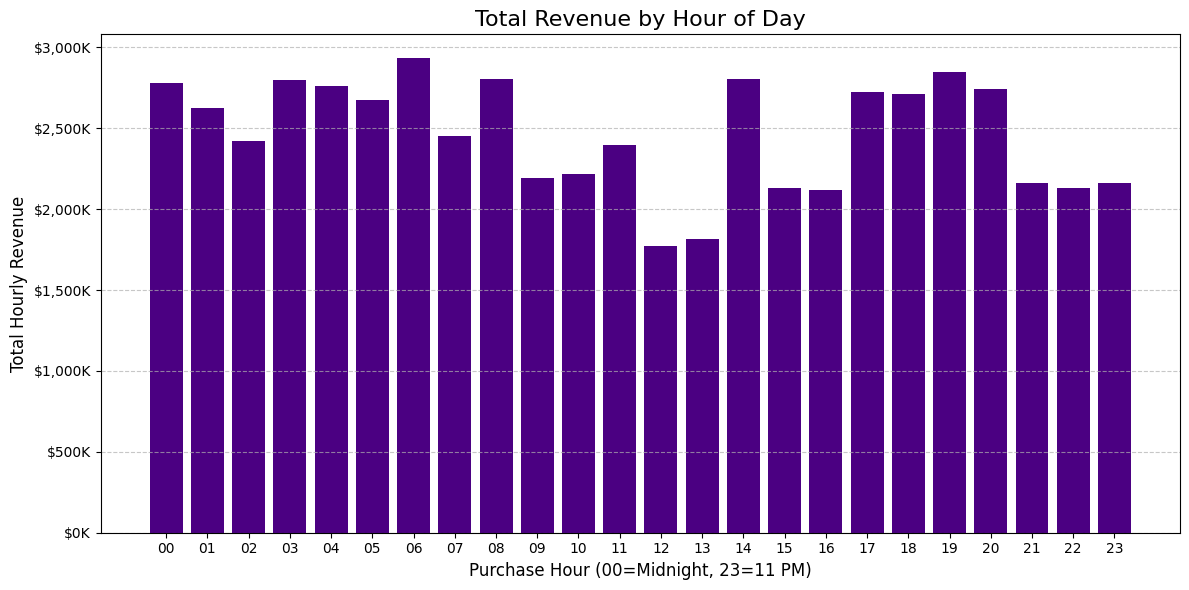

In [57]:
# The DataFrame is now clean!
hourly_df.sort_values(by='Purchase_Hour', inplace=True)

plt.figure(figsize=(12, 6))
plt.bar(hourly_df['Purchase_Hour'], hourly_df['Hourly_Revenue'], color='indigo')

plt.title('Total Revenue by Hour of Day', fontsize=16)
plt.xlabel('Purchase Hour (00=Midnight, 23=11 PM)', fontsize=12)
plt.ylabel('Total Hourly Revenue', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)

# Re-define the formatter for completeness
def k_formatter(x, pos):
    return f'${x/1000:,.0f}K'
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(k_formatter))

plt.tight_layout()
plt.show()